In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter

plt.rcParams.update({'font.family': 'cmr10', 'font.size': 12})
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.dpi'] = 100
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['axes.formatter.use_mathtext'] = True

%matplotlib inline

In [2]:
# Define a few useful functions 

def preview_img(index, data):
    """
    index: int, index of the image to display
    
    data: array, dataset to diplay an image from
    """
    if index > data.shape[0]:
        print(f"The index you choose must be less than {data.shape[0]}")
    else:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
        ax.matshow(data[index,...], cmap='gray')
        ax.set_axis_off()
        
def model_accuracy(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100

In [3]:
# If you have not already installed TensorFlow and Keras, un-comment and run the following lines

#! pip install tensorflow
# If you have a Mac and the above line didn't work, try the one below
#! pip install tensorflow-macos

#! pip install keras

# Exploring and preprocessing our data

In [4]:
# start by loading in data

from tensorflow.keras.datasets import mnist

(training_data, training_labels), (testing_data, testing_labels) = mnist.load_data()

print(training_data.shape, testing_data.shape)
print(training_labels.shape, testing_labels.shape)

Init Plugin
Init Graph Optimizer
Init Kernel
(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)


By default, the label associated with each image is the value of the digit shown in that image. Since we're only interested in whether or not the handwritten digit is even or odd, we want to adjust the labels so that every even digit is labeled by a zero, and every odd digit is labeled by a one.

In [5]:
training_labels[training_labels%2==0] = 0
training_labels[training_labels%2==1] = 1
testing_labels[testing_labels%2==0] = 0
testing_labels[testing_labels%2==1] = 1

With the labels sorted, let's make sure that the data matches what we expect. The training (testing) data contains 60,000 (10,000) 28x28 greyscale images of handwritten digits. Pick a few numbers between 0 and 59,999 and plug them into the <tt>preview_img</tt> function below.

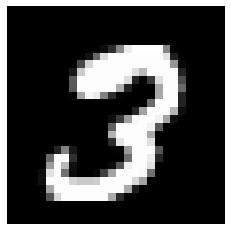

In [6]:
preview_img(12345, training_data)

For the network we'll be building today, we'll want to reformat each image as a column vector, and then stack all of those column vectors side-by-side into a 'matrix' that looks like $$\begin{bmatrix} | & | & | & \ldots & | \\ x^{[0]}_{i} & x^{[1]}_{i} & x^{[2]}_{i} & \ldots & x^{[N]}_{i} \\ | & | & | & \ldots & | \end{bmatrix}$$ where $x^{[k]}_{i}$ is the intensity of the $i$th pixel in the $k$th image, and $N$ is the total number of images we have (60,000 for the training set, 10,000 for the testing set)

There are network that allow us to train directly on images (Convolutional Neural Networks), but we won't be discussing those today.

In [7]:
training_data = training_data.reshape(-1, training_data.shape[1]*training_data.shape[2]).T
testing_data = testing_data.reshape(-1, testing_data.shape[1]*testing_data.shape[2]).T
training_labels = training_labels.reshape(1,-1)
testing_labels = testing_labels.reshape(1,-1)

# Defining the Model Architecture

We can think of our neural network in the following way:

![](Images/black_box_nn.png)

where the inner workings are quite literally (for now, at least) a black box. 

Inside this model, there are a number of $\textit{layers}$, corresponding to either our input data, the model's output, or some learned representation along the way. We say a layer is "hidden" if it isn't the model's input or output, since we typically don't access any of the information in those layers. If it's helpful, you can think of these layers as being column vectors. Our updated picture now looks like:

![](Images/nn_arch.png)

Each \emph{layer} consists of a certain number of $\textit{nodes}$. For our example, the number of nodes in the input layer will be the total number of pixels in the input image. We'll only have a single node in the output layer, since we want our model to learn whether a given input corresponds to one of two classes. 

The network we'll build today is called a $\textbf{Dense}$ network since every node in the $k$th layer depends on every node in the $k-1$th layer. Diagramatically, this looks like:

![](Images/dense_layout.png)

where each circle represents a node in a given layer, and each arrow indicates how much the node in one layer depends on the value of the node in the previous layer.

Mathematically, the value of the $i$th node in the $k$th layer is $$z^{[k]}_{i} = \displaystyle\sum_{j=1}^{N_{k-1}} w_{ij}z^{[k-1]}_{j} + b_{i}$$ where $w_{ij}$ is a matrix of weights connecting the $i$th node in the $k$th layer to all of the nodes in the $k-1$th layer, and $b_{i}$ is bias parameter that can also be learned. We can then do this operation for every node $i$ in layer $k$ by stacking them in a column. 

$$
\begin{bmatrix} x_{0}^{[k]} \\ x_{1}^{[k]} \\ \vdots \\ x_{N_{k}}^{[k]}\end{bmatrix} = 
\begin{bmatrix} w_{00} & w_{01} & \ldots & w_{0 N_{k-1}} \\ w_{10} & w_{11}  & \ldots &  w_{1 N_{k-1}} \\ \vdots & \vdots & \ddots & \vdots \\ w_{N_{k} 0} & w_{N_{k} 1} & \ldots &  w_{N_{k} N_{k-1}} \end{bmatrix}
\begin{bmatrix} x_{0}^{[k-1]} \\ x_{1}^{[k-1]} \\ \vdots \\ x_{N_{k-1}}^{[k-1]}\end{bmatrix} + 
\begin{bmatrix} b_{0}^{[k]} \\ b_{1}^{[k]} \\ \vdots \\ b_{N_{k}}^{[k]}\end{bmatrix}
$$

To summarize, the architecture of the network is determined by the the number of layers we use, and the number of nodes in each layer. The number of nodes in the input and output layers will be determined by our data and the task we ultimately want to do, but we are free to set the number of hidden layers as well as the number of nodes in each of those hidden layers. For simplicity, we will create a model with just a single hidden layer.

In [8]:
def nodes_per_layer(input_data, true_labels):
    """
    Define the number of nodes in each layer. The number of nodes in the input and output layer are determined 
    by our input data and true_labels, respectively. But, we are free to set the number of nodes 
    in the hidden layer.
    """
    
    n_inputs = input_data.shape[0]
    n_hidden = 5
    n_outputs = true_labels.shape[0]
    
    return (n_inputs, n_hidden, n_outputs)

In [9]:
def initialize_parameters(n_inputs, n_hidden, n_outputs):
    """
    Initialize all of the parameters used to train the model, given the number of nodes in each layer. 
    W1 will connect our input layer to the hidden layer, W2 will connect the input layer to the output layer. 
    To start, we will set both bias vectors to 0.
    """
    W1 = np.random.randn(n_hidden, n_inputs)*0.01
    b1 = np.zeros((n_hidden, 1))
    W2 = np.random.randn(n_outputs, n_hidden)
    b2 = np.zeros((n_outputs, 1))
    
    parameters = {"W1":W1, "b1":b1, "W2":W2, "b2":b2}
    
    return parameters

# Forward Propagation

With the architecture of our model defined, we can take the first step towards training it. Starting from our input data, we'll carry out the necessary operations to produce the model's prediction for each input's corresponding label. 

The power of machine learning comes from being able to learn non-linearities present in our data. Our current formulation of connecting layers , however, only allows us to learn linear combinations of our data. To correct this, we then need to pass each layer (with the exception of the input layer) through a nonlinear function, called an $\textit{activation}$ function. 

For the hidden layer, we'll be using the <tt>tanh</tt> function, though there are other choices we could have made. For the output layer though, we want to make sure that we choose a function who's domain is $[0,1]$ since the labels we want our model to predict are either 0 or 1. We will use the <tt>sigmoid</tt> activation function for the output layer. Note that if we were interested in a different task, we would want to choose a different activation function for the output layer. 

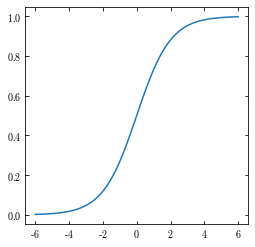

In [10]:
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    
    return s

fig, ax = plt.subplots(1, 1, figsize=(4,4))

x = np.linspace(-6, 6, 101)
ax.plot(x, sigmoid(x));

In [11]:
def forward_prop(input_data, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1, input_data) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    cache = {"Z1":Z1, "A1":A1, "Z2":Z2, "A2":A2}
    
    return A2, cache

For each event, we compute the 
$\textit{loss}$, which tells us how far off the network's guess was from the true label. For binary classification, the loss function we often us is the $\textbf{binary crossentropy}$ $$\mathcal{L}(\hat{y}, y) = -y\ln(\hat{y}) - (1-y)\ln(1-\hat{y})$$ where $y$ is the true label and $\hat{y}$ is the network's output (what we have been calling $A^{[2]}$). By eye, we can see that if the network's output matches the true label, the loss function will evaluate to zero.

We can them compute a related quantity, called the $\textit{cost}$
$$C[W^{[1]}, b^{[1]}, W^{[2]}, b^{[2]}] = \frac{1}{m}\displaystyle\sum_{i=1}^{m}\mathcal{L}(\hat{y}_{i}, y_{i})$$ which is just the average loss for each event in our training set and gives us a sense of how well our model is performing

In [12]:
def compute_cost(A2, true_labels, parameters):
    m = true_labels.shape[1]
    
    cost = -(1/m) * (np.dot(true_labels, np.log(A2.T)) + np.dot((1-true_labels), np.log(1-A2).T))
    cost = np.squeeze(cost)
    
    return cost

# Back Propagation

The goal of training our neural network is to have its predictions get better and better with each iteration. To do this, we need a way of updating the parameters in our network---the weight matrices and biases---depending on how well our network performed. 

Given that we rigidly defined the cost function, we know how it depends on every parameter in our network. So, we can work our ways backwards to figure out how we the cost depends on each parameter in the network. Diagramatically, we can think of this in the following way:

<img src='Images/back_prop.png'>

where $\frac{\partial C}{\partial W^{[2]}}$ tells us how $C$ depends on $W^{[2]}$. To actually compute this, we need to use the chain rule, which gives: 
$$ \frac{\partial C}{\partial W^{[2]}} = \frac{\partial C}{\partial A^{[2]}} \frac{\partial A^{[2]}}{\partial Z^{[2]}} \frac{\partial Z^{[2]}}{\partial W^{[2]}} =: \textrm{"dW2"} $$
We'll then need to repeat a similar calculation for $\textrm{"db2"} = \frac{\partial C}{\partial b^{[2]}}$, $\textrm{"dW1"} = \frac{\partial C}{\partial W^{[1]}}$, and $\textrm{"db1"} = \frac{\partial C}{\partial b^{[1]}}$

For the sake of time, these gradients are provided below, but try and go back and calculate each one to make sure you understand where they came from (you may find it easier to compute these gradients with respect to the loss (single event), rather than the cose (all events)). 

In [13]:
def back_prop(parameters, cache, input_data, true_labels):
    m = input_data.shape[1]

    W1 = parameters["W1"]
    W2 = parameters["W2"]

    A1 = cache["A1"]
    A2 = cache["A2"]

    dZ2 = A2 - true_labels
    dW2 = (1/m)*np.dot(dZ2, A1.T)
    db2 = (1/m)*np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = (1/m)*np.multiply(np.dot(W2.T, dZ2),(1-np.power(A1, 2)))
    dW1 = (1/m)*np.dot(dZ1, input_data.T)
    db1 = (1/m)*np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1":dW1, "db1":db1, "dW2":dW2, "db2":db2}

    return grads

To actually update all of the parameters, we use a $\textit{gradient descent}$ algorithm. The easiest way to explain this is diagramatically (image from https://towardsdatascience.com/quick-guide-to-gradient-descent-and-its-variants-97a7afb33add):

<img src='Images/1*iNPHcCxIvcm7RwkRaMTx1g.jpeg'>

We've computed the gradients of our cost function for each parameter, so we know how each parameter will affect the model's cost function. We then want to take a step of a certain size to a new value of each parameter, with that step being in the direction of the minimum value of the cost function. The size of this step, the $\textit{learning rate}$, is another hyperparameter that we are free to set ourselves, like the number of hidden layers and the number of nodes in each hidden layer.

In [14]:
def update_parameters(parameters, grads, learning_rate):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    W1 = W1-learning_rate*dW1
    b1 = b1-learning_rate*db1
    W2 = W2-learning_rate*dW2
    b2 = b2-learning_rate*db2

    parameters = {"W1":W1, "b1":b1, "W2":W2, "b2":b2}

    return parameters

# Putting it all together

Now that we know how to define the model architecture, propagate our input data forward to get the model's guess at the correct label, and update all of the parameters in our network based on how closely the model's predicted labels were to the true labels, let's put everything together and actually train our neural network.

We'll train our network for 1000 $\textit{epochs}$, or pass throughs of our entire training set. 

In [15]:
def nn_model(input_data, true_labels, n_hidden, num_iterations, learning_rate, print_cost=True):
    n_inputs = nodes_per_layer(input_data, true_labels)[0]
    n_outputs = nodes_per_layer(input_data, true_labels)[2]
    
    parameters = initialize_parameters(n_inputs, n_hidden, n_outputs)
    #W1 = parameters["W1"]
    #b1 = parameters["b1"]
    #W2 = parameters["W2"]
    #b2 = parameters["b2"]
    cost_list = []
    accuracy_list = []
    for i in range(0, num_iterations): 
        A2, cache = forward_prop(input_data, parameters)
        predictions = (A2 > 0.5)
        accuracy = model_accuracy(true_labels[0], predictions[0])
        cost = compute_cost(A2, true_labels, parameters)
        accuracy_list.append(accuracy)
        cost_list.append(cost)
        grads = back_prop(parameters, cache, input_data, true_labels)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i%100==0:
            print(f'After {i} iterations, the model\'s cost is {np.round(cost, 5)} and its accuracy is {np.round(accuracy, 2)}%')

    return parameters, cost_list, accuracy_list

In [16]:
def predict(parameters, input_data):
    A2, cache = forward_prop(input_data, parameters)
    predictions = (A2 > 0.5)

    return predictions

In [17]:
start=perf_counter()
parameters, cost_list, accuracy_list = nn_model(training_data, training_labels, n_hidden=4, 
                                                num_iterations=1001, learning_rate=10)
end=perf_counter()
print(f"This network took {np.round(end-start,2)} seconds to train.")

test_predictions = predict(parameters, testing_data)
print(f"Testing set accuracy: {np.round(model_accuracy(testing_labels[0], test_predictions[0]), 3)}%")

After 0 iterations, the model's cost is 1.08445 and its accuracy is 50.14%
After 100 iterations, the model's cost is 0.436 and its accuracy is 79.64%
After 200 iterations, the model's cost is 0.38629 and its accuracy is 83.25%
After 300 iterations, the model's cost is 0.35665 and its accuracy is 85.18%
After 400 iterations, the model's cost is 0.33655 and its accuracy is 86.52%
After 500 iterations, the model's cost is 0.32101 and its accuracy is 87.4%
After 600 iterations, the model's cost is 0.31051 and its accuracy is 87.9%
After 700 iterations, the model's cost is 0.30107 and its accuracy is 88.42%
After 800 iterations, the model's cost is 0.29284 and its accuracy is 88.88%
After 900 iterations, the model's cost is 0.28495 and its accuracy is 89.25%
After 1000 iterations, the model's cost is 0.27863 and its accuracy is 89.5%
This network took 208.53 seconds to train.
Testing set accuracy: 89.37%


Text(0, 0.5, 'Accuracy')

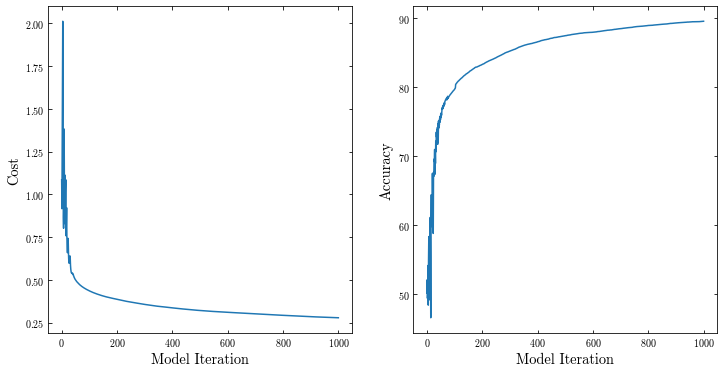

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

ax[0].plot(cost_list)
ax[0].set_xlabel('Model Iteration', fontsize='x-large')
ax[0].set_ylabel('Cost', fontsize='x-large')

ax[1].plot(accuracy_list)
ax[1].set_xlabel('Model Iteration', fontsize='x-large')
ax[1].set_ylabel('Accuracy', fontsize='x-large')

# Simplifying the process with Keras

While the above example is useful for de-mystifying machine learning and gaining an appreciation for what's going on under the hood, it won't be what you use (or want to use) in practice. 

Keras (https://keras.io) is a powerful, easy-to-use machine learning API built on top of TensorFlow2 (https://www.tensorflow.org). Here, we'll use Keras to build a neural network with an identical architecture, train that model on the same data, and see how it compares to the network we wrote from scratch.

In [19]:
import tensorflow as tf

In [20]:
# define and train a keras model

input_layer = tf.keras.layers.Input((training_data.T.shape[1],))
hidden_layer = tf.keras.layers.Dense(4, activation='tanh')(input_layer)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(hidden_layer)

keras_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
keras_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['acc'])

history = keras_model.fit(training_data.T, training_labels.T, verbose=1, validation_split=0.15, 
                          epochs=50, batch_size=256)

Metal device set to: Apple M1 Pro
Epoch 1/50


2022-02-24 16:56:35.066726: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-24 16:56:35.066838: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-24 16:56:35.199489: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-24 16:56:35.199662: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 22/200 [==>...........................] - ETA: 0s - loss: 0.7432 - acc: 0.4757

2022-02-24 16:56:35.303368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 1s 6ms/step - loss: 0.5138 - acc: 0.7398 - val_loss: 0.3921 - val_acc: 0.8462
Epoch 2/50
 12/200 [>.............................] - ETA: 0s - loss: 0.4182 - acc: 0.8242

2022-02-24 16:56:36.400655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 1s 5ms/step - loss: 0.3889 - acc: 0.8327 - val_loss: 0.3486 - val_acc: 0.8643
Epoch 3/50
200/200 [==============================] - 1s 5ms/step - loss: 0.3604 - acc: 0.8407 - val_loss: 0.3386 - val_acc: 0.8670
Epoch 4/50
200/200 [==============================] - 1s 5ms/step - loss: 0.3427 - acc: 0.8541 - val_loss: 0.3041 - val_acc: 0.8827
Epoch 5/50
200/200 [==============================] - 1s 5ms/step - loss: 0.3370 - acc: 0.8554 - val_loss: 0.3007 - val_acc: 0.8807
Epoch 6/50
200/200 [==============================] - 1s 5ms/step - loss: 0.3287 - acc: 0.8639 - val_loss: 0.2871 - val_acc: 0.8857
Epoch 7/50
200/200 [==============================] - 1s 5ms/step - loss: 0.3085 - acc: 0.8639 - val_loss: 0.3009 - val_acc: 0.8481
Epoch 8/50
200/200 [==============================] - 1s 5ms/step - loss: 0.3207 - acc: 0.8675 - val_loss: 0.3097 - val_acc: 0.8693
Epoch 9/50
200/200 [==============================] - 1s 5ms/step - loss: 0.3046 - acc:

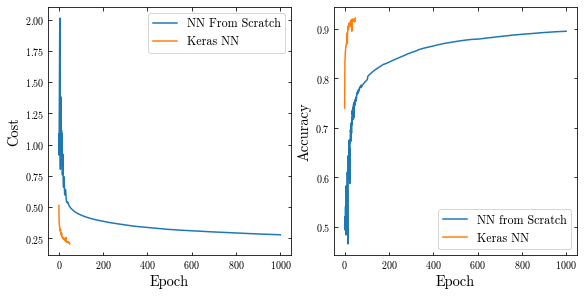

In [21]:
# how does the model we instantiated with Keras compare to the one we made from scratch?

fig, ax = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)

ax[0].plot(cost_list, label='NN From Scratch')
ax[0].plot(history.history['loss'], label='Keras NN')
ax[0].set_xlabel('Epoch', fontsize='x-large')
ax[0].set_ylabel('Cost', fontsize='x-large')
ax[0].legend(loc='upper right', fontsize='large')

ax[1].plot(0.01*np.array(accuracy_list), label='NN from Scratch')
ax[1].plot(history.history['acc'], label='Keras NN')
ax[1].set_xlabel('Epoch', fontsize='x-large')
ax[1].set_ylabel('Accuracy', fontsize='x-large')
ax[1].legend(loc='lower right', fontsize='large');